In [14]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
%run ../../scripts/mfss_model_train.py
%run ../../scripts/utils/data_processing.py

## Load train and test data

In [2]:
data_path = '../../data/processed/'

In [3]:
# Read in the Hannum dataset for training
hannum = pd.read_pickle(data_path + 'GSE40279_hannum/hannum32.pkl')
hannum_meta = pd.read_excel(data_path + 'GSE40279_hannum/hannum_pmeta.xlsx')

In [4]:
# Read in the Lehne datasat for testing
lehne = np.load(data_path + 'GSE55763_lehne/lehne32_reduced.npy')
lehne_meta = pd.read_excel(data_path + 'GSE55763_lehne/lehne_pmeta.xlsx')
lehne_cgs = list_reader(data_path + 'GSE55763_lehne/cgs')
lehne = pd.DataFrame(lehne, columns=lehne_cgs)

### Get the individual chronological age correlation of every CpG using the GSE40279 dataset as a reference (Requires download of processed GSE40279 dataset  Hannum32.pkl)

In [4]:
##Uncomment to run this process
# age_corrs = get_age_corrs(hannum, hannum_meta)
# age_corrs = age_corrs.reset_index(drop=True)

### Or read in the age correlations if you already have 'Hannum_age_corrs.xlsx' stored in 'cpg_sets' directory

In [5]:
age_corrs=pd.read_excel(data_path + 'cpg_sets/Hannum_age_corrs.xlsx')

### Filter out SNPs using the 450K manifest

In [6]:
manifest = pd.read_csv(data_path + 'metadata/450K_manifest.csv', low_memory=False)
# Get all SNP-associated CpGs in 450K array 
snps = set(manifest[~manifest.Probe_SNPs.isna()].Name)
no_snps = list(set(age_corrs.CpG)-snps)
age_corrs = age_corrs[age_corrs['CpG'].isin(no_snps)]

### GSE55763 has some missing CpGs so need to remove those from the age_corrs rows

In [7]:
overlap = list(set(lehne.columns)&set(age_corrs.CpG))

filtered_age_corrs= age_corrs[age_corrs['CpG'].isin(overlap)]
filtered_age_corrs.reset_index(inplace=True)

## Train an mFSS OLS model on the top 10,000 CpGs by strength of chronological age correlation, using GSE40279 (Hannum) for training and validation and GSE55763 (Lehne) for testing. Set patience=150

In [8]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(filtered_age_corrs.CpG.tolist()[:10000], hannum, hannum_meta,
                                                                             lehne, lehne_meta, 150,pos_weights=False)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

# Generate Figure 3b (top)

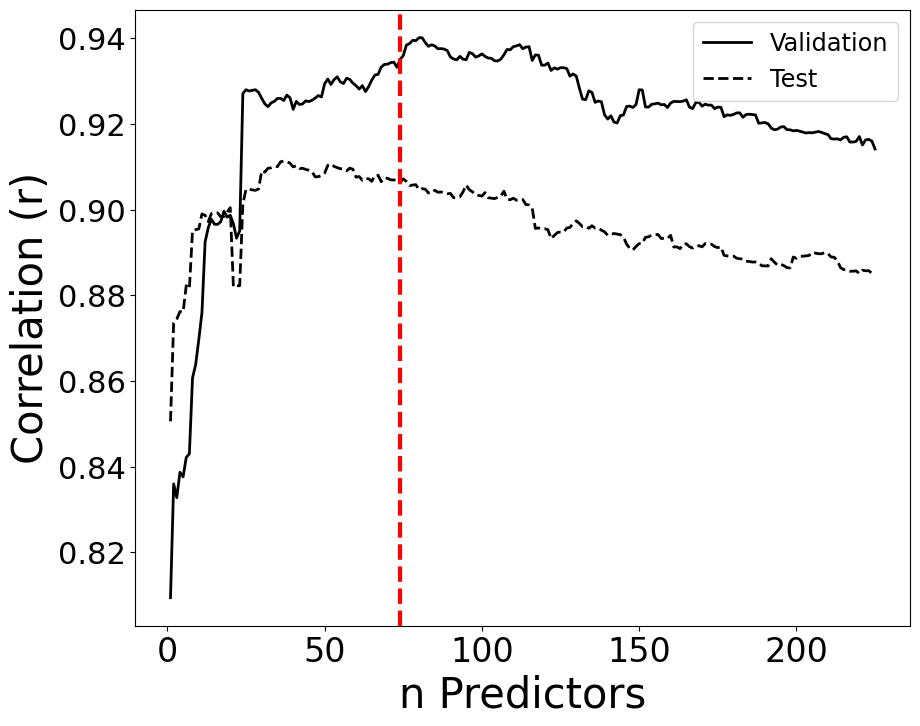

In [9]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=30)
plt.ylabel('Correlation (r)',fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=22)
plt.legend(loc='best', fontsize='xx-large')

# Generate Figure 3b (bottom)

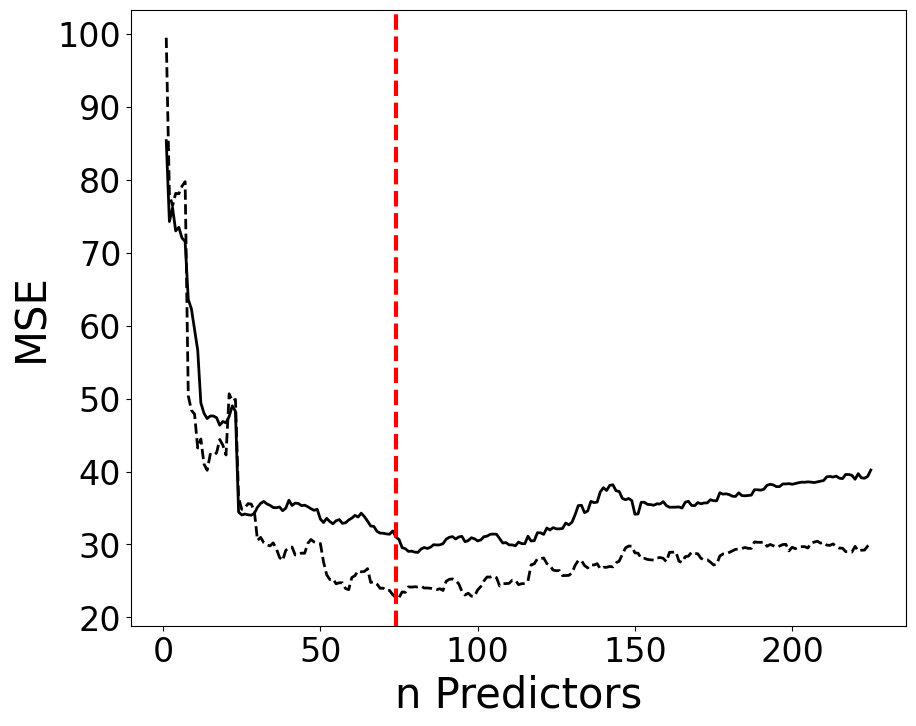

In [10]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=30);
plt.ylabel('MSE',fontsize=30);
plt.xticks(fontsize=24);
plt.yticks(fontsize=24);

## Create the OLS model based on the best iteration

In [12]:
age_corr_mfss_selection =filtered_age_corrs.CpG[:best_iter]
age_corr_mfss_model = LinearRegression(positive=False).fit(hannum[age_corr_mfss_selection], hannum_meta.age)

# Generate Figure 3c

Text(0.5, 1.0, 'GSE40279: r=0.95, p=0, MAE=3.5 yrs')

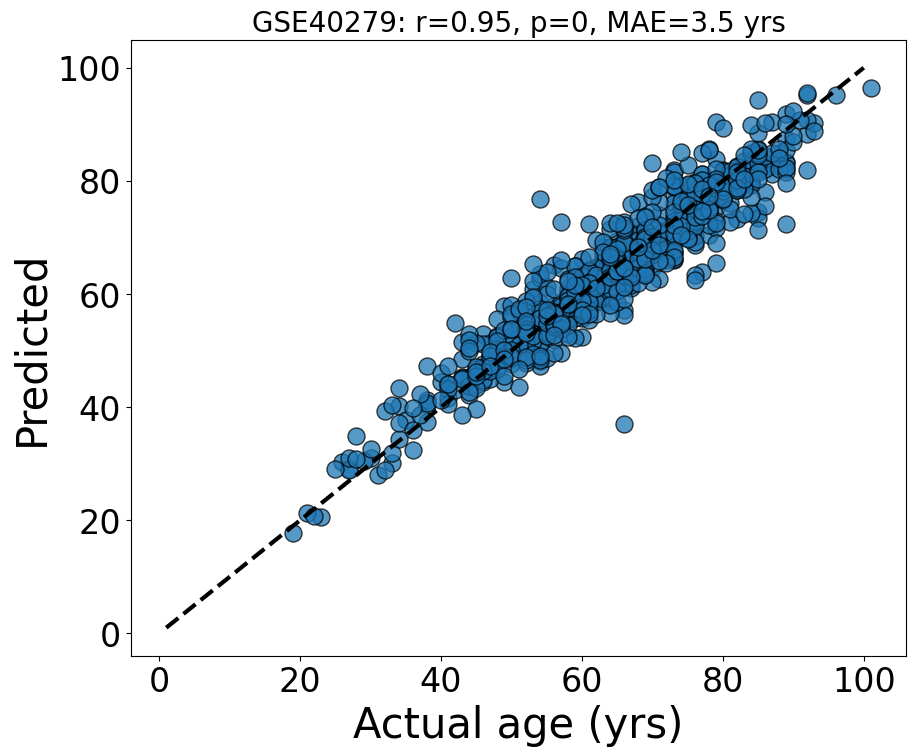

In [15]:
train_preds = age_corr_mfss_model.predict(hannum[age_corr_mfss_selection])

regression = stats.linregress(hannum_meta.age, train_preds)
slope, intercept, rvalue, pvalue, stderr = regression

mae = metrics.mean_absolute_error(hannum_meta.age, train_preds)

plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(x=hannum_meta.age, y=train_preds, alpha=0.75, s=150, edgecolor="k")
# sns.regplot(x=hannum_meta.age, y=train_preds, scatter=False,color="black", line_kws={"linestyle": "--"})
vals = np.linspace(1,100,100)
sns.lineplot(x=vals, y=vals,linewidth=3, color='k',linestyle='--')
plt.xlabel('Actual age (yrs)',fontsize=30)
plt.ylabel('Predicted',fontsize=30)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.title('{}: r={:.2f}, p={:.1g}, MAE={:.1f} yrs'.format(hannum_meta.series_id[0], rvalue, pvalue, mae),fontsize=20)

# Generate Figure 3d

Text(0.5, 1.0, 'GSE55763: r=0.90, p=0, MAE=3.7 yrs')

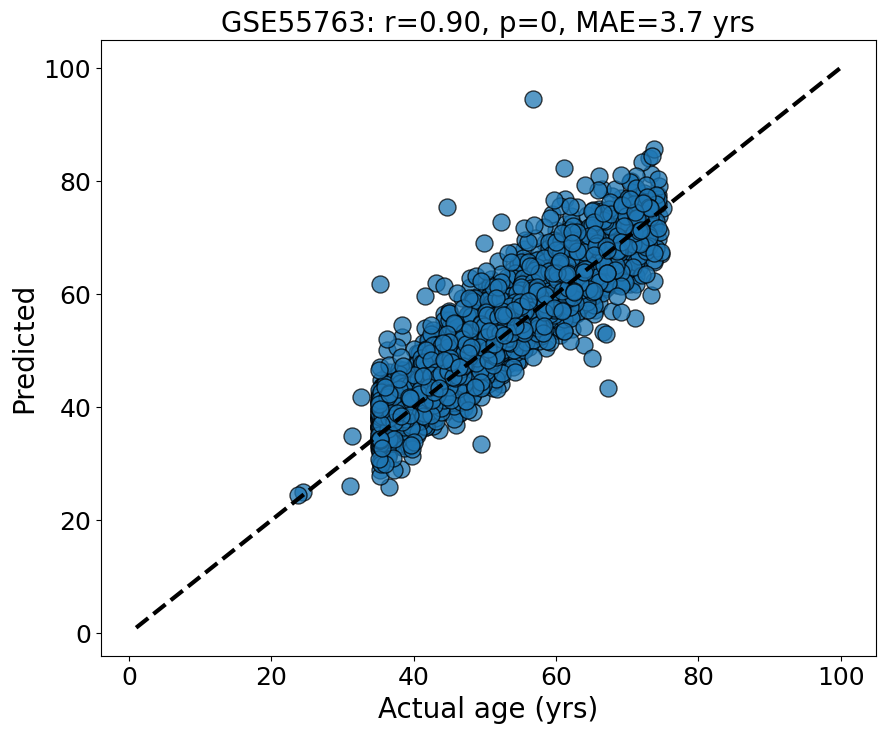

In [17]:
lehne_preds = age_corr_mfss_model.predict(lehne[age_corr_mfss_selection])

regression = stats.linregress(lehne_meta.age, lehne_preds)
slope, intercept, rvalue, pvalue, stderr = regression

mae = metrics.mean_absolute_error(lehne_meta.age, lehne_preds)

plt.figure(figsize=(10, 8)) 
# Create a scatter plot of the transformed data
sns.scatterplot(x=lehne_meta.age, y=lehne_preds, alpha=0.75, s=150, edgecolor="k")
# sns.regplot(x=lehne_meta.age, y=train_preds, scatter=False,color="black", line_kws={"linestyle": "--"})
vals = np.linspace(1,100,100)
sns.lineplot(x=vals, y=vals,linewidth=3, color='k',linestyle='--')
plt.xlabel('Actual age (yrs)',fontsize=20)
plt.ylabel('Predicted',fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title('{}: r={:.2f}, p={:.1g}, MAE={:.1f} yrs'.format(lehne_meta.series_id[0], rvalue, pvalue, mae),fontsize=20)